Hyperparameter exploration: plot the variation of the 3 hyperparameters vs added noise and vs number of physical model targets used in hyperparameter optimisation. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from simple_model import simple_model
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [2]:
data_dir = '/Users/joshnevin/physical_gps/david_data/'
snr = np.genfromtxt(open(str(data_dir) + "snr_david.csv", "r"), delimiter=",", dtype =float)
pch = np.genfromtxt(open(str(data_dir) + "power_david.csv", "r"), delimiter=",", dtype =float)

In [3]:
# snr = snr[:16] # -10 to 5 dBm
# pch = pch[:16] 
# snr = snr[1:14]  # -8 to 4 dBm
# pch = pch[1:14] 
# snr = snr[3:10] # -6 to 0 dBm  # 3 dBm around peak 
# pch = pch[3:10] 
snr = snr[1:15] # -9 to 4 dBm  # 2 dB SNR penalty around the peak 
pch = pch[1:15] 

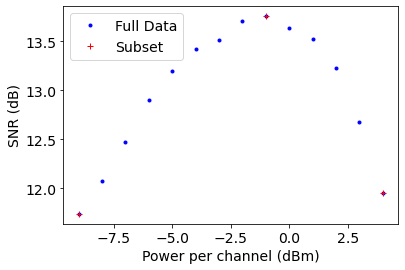

In [4]:
# inds = [0, 4, 8, 12, 15]  # for -10 to 5 dBm
# snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]], snr[inds[3]], snr[inds[4]]])
# pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]], pch[inds[3]], pch[inds[4]]])
# inds = [0, 3, 6, 9, 12]  # for -8 to 4 dBm
# snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]], snr[inds[3]], snr[inds[4]]])
# pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]], pch[inds[3]], pch[inds[4]]])
# inds = [0, 3, -1]  # -6 to 0 dBm, three measurements 
# snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]]])
# pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]]])
inds = [0, 5, -1]  # for -9 to 4 dBm, three meas.
snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]]])
pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]]])
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_sub, snr_sub, 'r+', label='Subset')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

In [5]:
def gen_phys_targets(pch, num_pts_phys, rseed, sig, a_opt, b_opt):
    pch_gn = np.linspace(pch[0], pch[-1], num_pts_phys)
    #snr_phys = (model.predict_snr(pch_gn)).reshape(-1,1)
    snr_phys = snr_simple_gen(pch_gn, a_opt, b_opt, rseed, sig)
    return pch_gn, snr_phys
def train_phys_gp(pch, pch_phys, snr, snr_phys, pch_pred):
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    pch_phys = pch_phys.reshape(-1,1)
    pch_pred = pch_pred.reshape(-1,1)
    snr = snr.reshape(-1,1)
    snr_phys = snr_phys.reshape(-1,1)
    kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-8, 1e5)) +  W(1, (1e-5,1e5))
    gpr_phys = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
    gpr_phys.fit_phys(pch, pch_phys, snr, snr_phys)
    mu_sk_phys, std_sk_phys = gpr_phys.predict(pch_pred, return_std=True)
    std_sk_phys = np.reshape(std_sk_phys,(np.size(std_sk_phys), 1)) 
    theta_phys = gpr_phys.kernel_.theta
    lml_phys = gpr_phys.log_marginal_likelihood()
    return mu_sk_phys, std_sk_phys, theta_phys, lml_phys
def train_standard_gp(pch, snr, pch_pred):
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    snr = snr.reshape(-1,1)
    pch_pred = pch_pred.reshape(-1,1)
    kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-8,1e5))
    gpr = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
    gpr.fit(pch, snr)
    mu_sk, std_sk = gpr.predict(pch_pred, return_std=True)
    std_sk = np.reshape(std_sk,(np.size(std_sk), 1)) 
    theta = gpr.kernel_.theta
    lml = gpr.log_marginal_likelihood()
    return mu_sk, std_sk, theta, lml
def convert_to_lin(x):
    return 10**(x/10)
def convert_to_db(x):
    return 10*np.log10(x)
def convert_to_dbm(x):
    return 10*np.log10(x/1e-3)
def convert_to_lin_dbm(x):
    return 1e-3*convert_to_lin(x)
def snr_simple_gen(p_in, a, b, rseed, sig):
        np.random.seed(rseed)
        p_in = p_in + np.random.normal(0, sig, len(p_in))
        p_in = convert_to_lin_dbm(p_in) # W
#         return convert_to_db(1/( (a*p_in**(-1) + b*p_in**2) + 1/29.2  ))
        return convert_to_db(1/( (a*p_in**(-1) + b*p_in**2) + 1/convert_to_lin(14.78)  ))

In [6]:
def apply_b2b(snr, b2b):
    return convert_to_db(1/(1/convert_to_lin(snr) + 1/convert_to_lin(b2b)))
# snr_ssfm = [15.77, 17.71, 19.49, 20.76, 20.64, 18.54, 15.09]  
# pch_ssfm = [-8, -6, -4, -2, 0, 2, 4]
# snr_ssfm = [14.78, 20.94, 15.09]  
# pch_ssfm = [ -9, -1, 4]
snr_ssfm = [15.77, 20.64, 15.09]  
pch_ssfm = [ -8, 0, 4]
#snr_ssfm_m = [apply_b2b(i, convert_to_db(29.2)) for i in snr_ssfm]
snr_ssfm_m = [apply_b2b(i, 14.8) for i in snr_ssfm]

In [7]:
sim_model = simple_model()

In [8]:
snr_ssfm = np.array(snr_ssfm)
pch_ssfm = np.array(pch_ssfm)
snr_ssfm_m = np.array(snr_ssfm_m)

In [9]:
opt_vals = sim_model.fit(pch_ssfm.reshape(len(pch_ssfm),), snr_ssfm.reshape(len(snr_ssfm),),
                         init_guess = np.array([1e-5, 1e3]))

In [10]:
a_opt, b_opt = opt_vals[0]
pch_sim_comp = np.linspace(pch[0], pch[-1], 30)
snr_sim = snr_simple_gen(pch_sim_comp, a_opt, b_opt, 1, 0.5/3)
print(a_opt)
print(b_opt)

4.121731562907489e-06
4537.197643412776


In [11]:
num_pts_phys = 15

In [12]:
pch_gn_david = np.linspace(pch[0], pch[-1], num_pts_phys)
snr_gn_david = snr_simple_gen(pch_gn_david, a_opt, b_opt, 1, 0.5/3)
pch_pred = np.arange(pch[-1], pch[0]+0.1, 0.1)

In [13]:
mu_sk_phys, std_sk_phys, theta_phys, lml_phys = train_phys_gp(pch_sub, pch_gn_david, snr_sub, snr_gn_david, pch_pred)
mu_sk_p2_phys = mu_sk_phys + 2*std_sk_phys 
mu_sk_n2_phys = mu_sk_phys - 2*std_sk_phys 

In [14]:
mu_sk, std_sk, theta, lml = train_standard_gp(pch, snr, pch_pred)
mu_sk_p2 = mu_sk + 2*std_sk 
mu_sk_n2 = mu_sk - 2*std_sk 

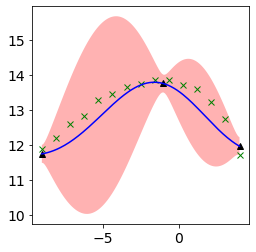

In [15]:
f, ax = plt.subplots()
plt.plot(pch_gn_david, snr_gn_david, 'gx')
plt.plot(pch_sub, snr_sub, 'k^')
plt.plot(pch_pred, mu_sk_phys, 'b-')
plt.fill(np.concatenate([pch_pred, pch_pred[::-1]]),
            np.concatenate([mu_sk_p2_phys,
                            (mu_sk_n2_phys)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.show()

In [16]:
def hyp_var_sig(sig_range, pch, num_pts_phys, snr, pch_pred):
    mus = []
    ls = []
    sigs = []
    lmls = []
    pred_stds = []
    mses = []
    for sig in sig_range:  
        #nsr_s = convert_to_db(sig*convert_to_lin(-16))
        pch_gn, snr_phys = gen_phys_targets(pch, num_pts_phys, 1, sig, a_opt, b_opt)
        pred_mean, pred_std, theta_phys, lml_phys = train_phys_gp(pch, pch_gn, snr, snr_phys, pch_pred)
        mus.append(theta_phys[0])
        ls.append(theta_phys[1])
        sigs.append(theta_phys[2])
        lmls.append(lml_phys)
        pred_stds.append(np.mean(pred_std))
        mses.append(calc_mse(snr, pred_mean))
    return mus, ls, sigs, lmls, pred_stds, mses
def hyp_var_num_pts(sigma, pch, num_pts_range, snr, pch_pred):
    mus = []
    ls = []
    sigs = []
    lmls = []
    pred_stds = []
    mses = []
    for num_pts in num_pts_range:
        pch_gn, snr_phys = gen_phys_targets(pch, num_pts, 2, sigma, a_opt, b_opt)
        pred_mean, pred_std, theta_phys, lml_phys = train_phys_gp(pch, pch_gn, snr, snr_phys, pch_pred)
        mus.append(theta_phys[0])
        ls.append(theta_phys[1])
        sigs.append(theta_phys[2])
        lmls.append(lml_phys)
        pred_stds.append(np.mean(pred_std))
        mses.append(calc_mse(snr, pred_mean))
    return mus, ls, sigs, lmls, pred_stds, mses
def calc_mse(data, y):
    return np.mean(((data - y)**2)**0.5)

In [17]:
#np.arange(0.1, 0.21, 0.01)
np.arange(0.1, 0.41, 0.02)

array([0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 ,
       0.32, 0.34, 0.36, 0.38, 0.4 ])

In [18]:
#sig_range = np.arange(0.1, 0.21, 0.01) 
sig_range = np.arange(0.1, 0.41, 0.02) 
#mus, ls, sigs, lmls, pred_stds, mses = hyp_var_sig(sig_range, pch, 15, snr, pch)
mus, ls, sigs, lmls, pred_stds, mses = hyp_var_sig(sig_range, pch_sub, 15, snr_sub, pch_pred)
lin_mus = np.exp(mus)
lin_ls = np.exp(ls)
lin_sigs = np.exp(sigs)
lin_mls = np.exp(lmls)

In [19]:
# GN_mus = np.genfromtxt(open("shared_data/GN_hyp_sig_h1.csv", "r"), delimiter=",", dtype =float)
# GN_ls = np.genfromtxt(open("shared_data/GN_hyp_sig_h2.csv", "r"), delimiter=",", dtype =float)
# GN_sigs = np.genfromtxt(open("shared_data/GN_hyp_sig_h3.csv", "r"), delimiter=",", dtype =float)
# GN_pred_stds = np.genfromtxt(open("shared_data/GN_hyp_sig_pred_stds.csv", "r"), delimiter=",", dtype =float)

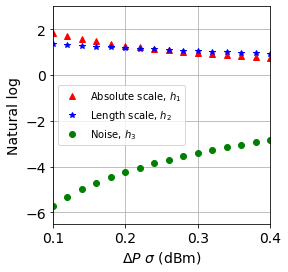

In [26]:
f, ax = plt.subplots()
plt.plot(sig_range, mus, 'r^', label='Absolute scale, $h_1$')
#plt.plot(sig_range, GN_mus, 'rx', label='GN $h_1$')
plt.plot(sig_range, ls, 'b*', label='Length scale, $h_2$')
#plt.plot(sig_range, GN_ls, 'b+', label='GN $h_2$')
plt.plot(sig_range, sigs, 'go', label='Noise, $h_3$')
#plt.plot(sig_range, GN_sigs, 'gX', label='GN $h_3$')
#plt.plot(sig_range, lmls, 'c.', label='Marginal likelihood')
plt.legend(ncol = 1, prop={'size':10})
plt.xlim([sig_range[0], sig_range[-1]])
#plt.xticks([0.005, 0.015, 0.025, 0.035, 0.045, 0.055])
#ax.set_xticklabels([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
#plt.yticks([-6, -4, -2, 0, 2, 3])
plt.ylim([-6.5, 3])
plt.xlabel("$\Delta P$ $\sigma$ (dBm)")
plt.ylabel("Natural log")
f.patch.set_facecolor('w')
plt.grid()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.savefig('figures/hyp_exp_sig_comb.pdf', dpi=200,bbox_inches='tight')
plt.show()

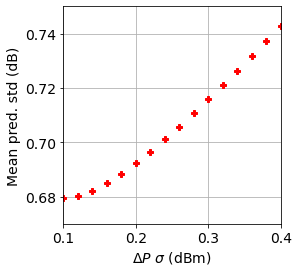

In [29]:
f, ax = plt.subplots()
plt.plot(sig_range, pred_stds, 'rP', label='SSFM')
#plt.plot(sig_range, GN_pred_stds, 'b*', label='GN')
plt.xlim([sig_range[0], sig_range[-1]])
#plt.xticks([0.005, 0.015, 0.025, 0.035, 0.045, 0.055])
#ax.set_xticklabels([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
# plt.yticks([0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05])
plt.ylim([0.67, 0.75])
plt.xlabel("$\Delta P$ $\sigma$ (dBm)")
plt.ylabel("Mean pred. std (dB)")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.grid()
#plt.legend(ncol = 1, prop={'size':10})
#plt.savefig('figures/david_hyp_expl_pred_std_pvar.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/final_pred_std_sig.pdf', dpi=200,bbox_inches='tight')
plt.savefig('figures/pred_std_sig_comb.pdf', dpi=200,bbox_inches='tight')
plt.show()

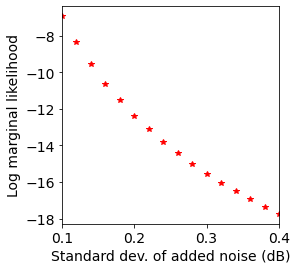

In [30]:
f, ax = plt.subplots()
#plt.plot(sig_range, lin_mus, 'r+', label='Absolute scale')
#plt.plot(sig_range, lin_ls, 'bx', label='Length scale')
plt.plot(sig_range, lmls, 'r*')
#plt.legend(ncol = 2, prop={'size':10})
plt.xlim([sig_range[0], sig_range[-1]])
#plt.xticks([0.01, 0.03, 0.05, 0.07, 0.09, 0.11])
plt.xlabel("Standard dev. of added noise (dB)")
plt.ylabel("Log marginal likelihood")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/david_hyp_expl_lml.pdf', dpi=200,bbox_inches='tight')
plt.show()

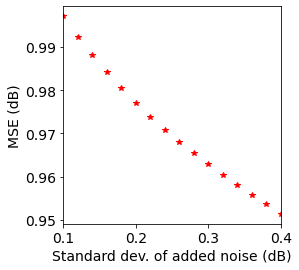

In [31]:
f, ax = plt.subplots()
plt.plot(sig_range, mses, 'r*')
#plt.legend(ncol = 2, prop={'size':10})
plt.xlim([sig_range[0], sig_range[-1]])
#plt.xticks([0.01, 0.03, 0.05, 0.07, 0.09, 0.11])
plt.xlabel("Standard dev. of added noise (dB)")
plt.ylabel("MSE (dB)")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/david_hyp_expl_lml.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [32]:
mses[0] - mses[-1]

0.045822029564536626

In [33]:
num_pts_range = np.arange(2, 41, 2, dtype=int)
#mus_p, ls_p, sigs_p, lmls_p, pred_stds_p, mses_p = hyp_var_num_pts(nsr_std, pch, num_pts_range, snr)
mus_p, ls_p, sigs_p, lmls_p, pred_stds_p, mses_p = hyp_var_num_pts(0.5/3, pch_sub, num_pts_range, snr_sub, pch_pred)
lin_mus = np.exp(mus)
lin_ls = np.exp(ls)
lin_sigs = np.exp(sigs)
lin_mls = np.exp(lmls)

/Users/joshnevin/sklearnforked/scikit-learn/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [34]:
# GN_mus_p = np.genfromtxt(open("shared_data/GN_hyp_npts_h1.csv", "r"), delimiter=",", dtype =float)
# GN_ls_p = np.genfromtxt(open("shared_data/GN_hyp_npts_h2.csv", "r"), delimiter=",", dtype =float)
# GN_sigs_p = np.genfromtxt(open("shared_data/GN_hyp_npts_h3.csv", "r"), delimiter=",", dtype =float)
# GN_pred_stds_p = np.genfromtxt(open("shared_data/GN_hyp_npts_pred_stds.csv", "r"), delimiter=",", dtype =float)

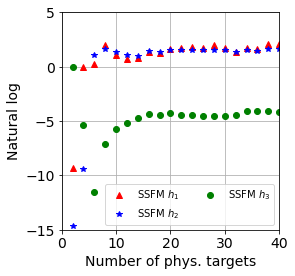

In [35]:
f, ax = plt.subplots()
plt.plot(num_pts_range, mus_p, 'r^', label='SSFM $h_1$')
#plt.plot(num_pts_range, GN_mus_p, 'rx', label='GN $h_1$')
plt.plot(num_pts_range, ls_p, 'b*', label='SSFM $h_2$')
#plt.plot(num_pts_range, GN_ls_p, 'b+', label='GN $h_2$')
plt.plot(num_pts_range, sigs_p, 'go', label='SSFM $h_3$')
#plt.plot(num_pts_range, GN_sigs_p, 'gX', label='GN $h_3$')
#plt.plot(sig_range, lmls, 'c.', label='Marginal likelihood')
plt.legend(ncol=2, prop={'size':10})
plt.xlim([0, 40])
plt.xticks([0, 10, 20, 30, 40])
# plt.yticks([-8, -6, -4, -2, 0, 2, 4, 6])
plt.ylim([-15, 5])
plt.xlabel("Number of phys. targets")
plt.ylabel("Natural log")
f.patch.set_facecolor('w')
plt.grid()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/david_hyp_expl_num_pts_all_pvar.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/final_hyp_exp_nphys.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/hyp_exp_npts_comb.pdf', dpi=200,bbox_inches='tight')
plt.show()

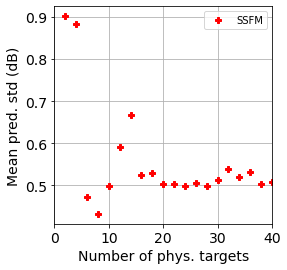

In [36]:
f, ax = plt.subplots()
plt.plot(num_pts_range, pred_stds_p, 'rP', label='SSFM')
#plt.plot(num_pts_range, GN_pred_stds_p, 'b*', label='GN')
plt.xlim([0, 40])
#plt.xticks([5, 10, 15, 20, 25, 30])
plt.xticks([0, 10, 20, 30, 40])
# plt.yticks([0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.03])
#plt.ylim([0, 0.8])
plt.xlabel("Number of phys. targets")
plt.ylabel("Mean pred. std (dB)")
f.patch.set_facecolor('w')
plt.grid()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.legend(ncol = 1, prop={'size':10})
#plt.savefig('figures/david_hyp_expl_num_pts_pred_std_pvar.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/final_pred_std_nphys.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/pred_std_npts_comb.pdf', dpi=200,bbox_inches='tight')
plt.show()

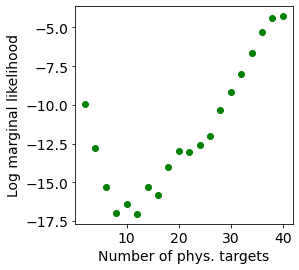

In [61]:
f, ax = plt.subplots()
plt.plot(num_pts_range, lmls_p, 'go')
# plt.xlim([5, 30])
# plt.xticks([5, 10, 15, 20, 25, 30])
plt.xlabel("Number of phys. targets")
plt.ylabel("Log marginal likelihood")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/david_hyp_expl_num_pts_lml.pdf', dpi=200,bbox_inches='tight')
plt.show()

We expect this behaviour, as the log marginal likelihood scales with the number of points. 

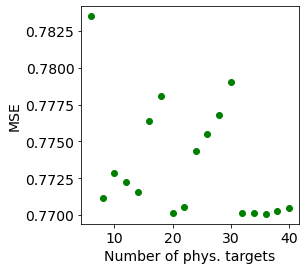

In [62]:
f, ax = plt.subplots()
plt.plot(num_pts_range[2:], mses_p[2:], 'go')
# plt.xlim([5, 30])
# plt.xticks([5, 10, 15, 20, 25, 30])
plt.xlabel("Number of phys. targets")
plt.ylabel("MSE")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/david_hyp_expl_num_pts_pred_mean.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [63]:
mses_p[2] - mses_p[-1]

0.013050725167952137

Predictive mean is unchanged to within a precision of 0.01 dB after the initial period of burn-in.